# Recursive multi-step forecasting

Source: https://skforecast.org/0.13.0/user_guides/autoregresive-forecaster

In [1]:
# !pip install skforecast

In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.datasets import fetch_dataset
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

### 0. Data

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


In [4]:
# show data time serie
data

y    datetime
0    0.429795  1991-07-01
1    0.400906  1991-08-01
2    0.432159  1991-09-01
3    0.492543  1991-10-01
4    0.502369  1991-11-01
..        ...         ...
199  0.761822  2008-02-01
200  0.649435  2008-03-01
201  0.827887  2008-04-01
202  0.816255  2008-05-01
203  0.762137  2008-06-01

[204 rows x 2 columns]

In [5]:
# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

In [6]:
data

datetime
1991-07-01    0.429795
1991-08-01    0.400906
1991-09-01    0.432159
1991-10-01    0.492543
1991-11-01    0.502369
                ...   
2008-02-01    0.761822
2008-03-01    0.649435
2008-04-01    0.827887
2008-05-01    0.816255
2008-06-01    0.762137
Freq: MS, Name: y, Length: 204, dtype: float64

In [7]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

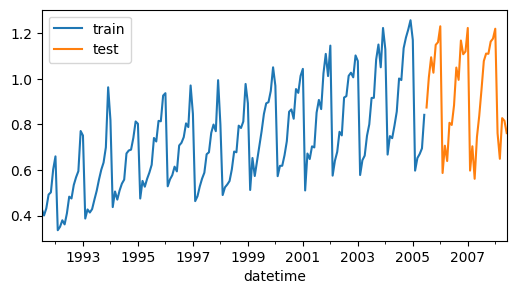

In [8]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend()

### 2. Create and train forecaster

Parece ser muy similar al modelo de nixtla para forecast utilizando modelos de ML.
Se crea un objeto el cual se le pasan modelos a entrenar y transformaciones de la feature (lags y otras) y entrena un modelo de ML utilizando esas transformaciones y predice una instancia a futuro (con enfoque recursivo permite hace forecast a N horizonte de tiempo a futuro)

In [9]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 15 # signfica que se pasan 15 lags
             )

In [10]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-09-20 17:45:09 
Last fit date: None 
Skforecast version: 0.13.0 
Python version: 3.10.14 
Forecaster id: None

In [11]:
# entrenar modelo
forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-09-20 17:45:09 
Last fit date: 2024-09

### 3. Prediction

In [12]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    1.020833
2005-08-01    1.021721
2005-09-01    1.093488
Freq: MS, Name: pred, dtype: float64

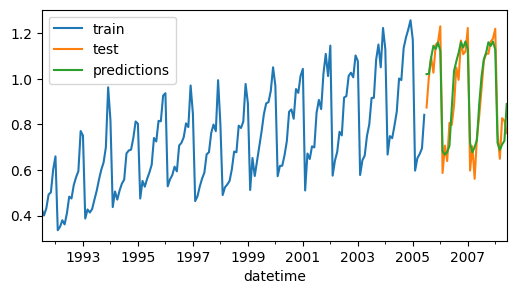

In [13]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [14]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.006023571131075229


### 4. Predict intervals

In [15]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, interval=[5, 95], n_boot=100)
predictions.head(3)

pred  lower_bound  upper_bound
2005-07-01  1.020833     0.975794     1.082322
2005-08-01  1.021721     0.976413     1.064850
2005-09-01  1.093488     1.010195     1.154976

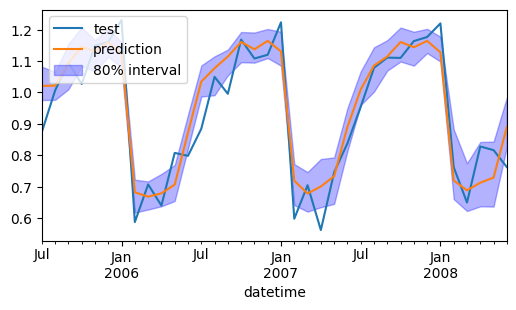

In [16]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test.plot(ax=ax, label="test")
predictions['pred'].plot(ax=ax, label="prediction")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'blue',
    alpha = 0.3,
    label = '80% interval'
)
ax.legend(loc="upper left");

### 5. Feature importances

In [17]:
forecaster.get_feature_importances()

feature  importance
11  lag_12         100
10  lag_11          43
0    lag_1          41
1    lag_2          41
5    lag_6          36
13  lag_14          33
2    lag_3          31
6    lag_7          30
14  lag_15          30
8    lag_9          26
12  lag_13          26
9   lag_10          22
7    lag_8          17
3    lag_4          15
4    lag_5          15

### 6. Extract training matrices
To examine how data is being transformed, it is possible to use the create_train_X_y method to generate the matrices that the forecaster is using to train the model. This approach enables gaining insight into the specific data manipulations that occur during the training process.

In [18]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data_train)

# mostrar las features que generó el forecaster
X_train.head(3)

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
datetime                                                                 
1992-10-01  0.534761  0.475463  0.483389  0.410534  0.361801  0.379808   
1992-11-01  0.568606  0.534761  0.475463  0.483389  0.410534  0.361801   
1992-12-01  0.595223  0.568606  0.534761  0.475463  0.483389  0.410534   

               lag_7     lag_8     lag_9    lag_10    lag_11    lag_12  \
datetime                                                                 
1992-10-01  0.351348  0.336220  0.660119  0.602652  0.502369  0.492543   
1992-11-01  0.379808  0.351348  0.336220  0.660119  0.602652  0.502369   
1992-12-01  0.361801  0.379808  0.351348  0.336220  0.660119  0.602652   

              lag_13    lag_14    lag_15  
datetime                                  
1992-10-01  0.432159  0.400906  0.429795  
1992-11-01  0.492543  0.432159  0.400906  
1992-12-01  0.502369  0.492543  0.432159

In [19]:
y_train.head()

datetime
1992-10-01    0.568606
1992-11-01    0.595223
1992-12-01    0.771258
1993-01-01    0.751503
1993-02-01    0.387554
Freq: MS, Name: y, dtype: float64

### 7. Prediction on training data

In [20]:
# Usar el método para generar las features X y el target y
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data_train)

In [21]:
# Predict using the internal regressor

#### AQUI SE PREDICE CON EL OBJETO SUBYACENTE (EL MODELO DE SKLEARN)
# ==============================================================================
predictions_training = forecaster.regressor.predict(X_train)
predictions_training[:4]

array([0.55145568, 0.57320468, 0.73750462, 0.73500079])

### 8. Extract prediction matrices
Skforecast provides the create_predict_X method to generate the matrices that the forecaster is using to make predictions. This method can be used to gain insight into the specific data manipulations that occur during the prediction process.

In [22]:
# Create input matrix for predict method

# acá crea las features utilizada para hacer el forecast con horizonte H. Es decir, a medida que se aleja en el horizonte
# más de estas features son predicciones previas
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=5)
X_predict

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
2005-07-01  0.842263  0.695248  0.670505  0.652590  0.597639  1.170690   
2005-08-01  1.020833  0.842263  0.695248  0.670505  0.652590  0.597639   
2005-09-01  1.021721  1.020833  0.842263  0.695248  0.670505  0.652590   
2005-10-01  1.093488  1.021721  1.020833  0.842263  0.695248  0.670505   
2005-11-01  1.145198  1.093488  1.021721  1.020833  0.842263  0.695248   

               lag_7     lag_8     lag_9    lag_10    lag_11    lag_12  \
2005-07-01  1.257238  1.216037  1.181011  1.134432  0.994864  1.001593   
2005-08-01  1.170690  1.257238  1.216037  1.181011  1.134432  0.994864   
2005-09-01  0.597639  1.170690  1.257238  1.216037  1.181011  1.134432   
2005-10-01  0.652590  0.597639  1.170690  1.257238  1.216037  1.181011   
2005-11-01  0.670505  0.652590  0.597639  1.170690  1.257238  1.216037   

              lag_13    lag_14    lag_15  
2005-07-01  0.856803  0.795129  0.739986  
2005-08-01  1.001593  0.856803  0.795129  
2005-09-01  0.994864  1.001593  0.856803  
2005-10-01  1.134432  0.994864  1.001593  
2005-11-01  1.181011  1.134432  0.994864

### 9. Differentiation
Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

In [23]:
# Create and fit forecaster
# ==============================================================================
# forecaster = ForecasterAutoreg(
#                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
#                 lags            = 15,
#                 differentiation = 1
#             )
#
#forecaster.fit(y=data_train)
#forecaster

In [24]:
# Predict
# ==============================================================================
#predictions = forecaster.predict(steps=36)
# predictions.head(3)

### 10. Guardar modelo
Source: https://skforecast.org/0.13.0/user_guides/save-load-forecaster

In [29]:
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [32]:
# Save model
# ==============================================================================
path_fcster_model = 'models/forecaster_001.joblib'
save_forecaster(forecaster, file_name= path_fcster_model, verbose=False)

In [33]:
# Load model
# ==============================================================================
forecaster_loaded = load_forecaster(path_fcster_model, verbose=True)

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-09-20 17:45:09 
Last fit date: 2024-09

In [34]:
forecaster_loaded.predict(5)

2005-07-01    1.020833
2005-08-01    1.021721
2005-09-01    1.093488
2005-10-01    1.145198
2005-11-01    1.131161
Freq: MS, Name: pred, dtype: float64

### 11. OWN: Obtener el modelo de sklearn subyacente y probar hacer mis propias predicciones

In [26]:
# objeto forecaster de sklearn
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-09-20 17:45:09 
Last fit date: 2024-09

In [28]:
# obtener el regresor
forecaster.regressor

LGBMRegressor(random_state=123, verbose=-1)

In [37]:
forecaster.regressor.predict([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]) # predicción de prueba llamando el modelo subyacente

array([1.15375407])